In [3]:
from langchain_tavily import TavilySearch

tool = TavilySearch(
    tavily_api_key="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",
    max_results=2)
tools = [tool]
tool.invoke("李超是谁?")

{'query': '李超是谁?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://baike.baidu.com/item/%E6%9D%8E%E8%B6%85/4769379',
   'title': '李超_百度百科',
   'content': '李超，男，汉族，1965年12月出生，河南焦作人，管理学博士。曾任周小川同志秘书。现任中国证券监督管理委员会党委委员、副主席。',
   'score': 0.8668671,
   'raw_content': None},
  {'url': 'https://baike.baidu.com/item/%E6%9D%8E%E8%B6%85/4769479',
   'title': '李超_百度百科',
   'content': '李超，1984年2月21日出生于山东省济南市，中国内地影视男演员，毕业于上海戏剧学院2001级表演系本科。2004年，出演个人首部电视剧《白银谷》，从而正式进入演艺圈。2005年，',
   'score': 0.85825616,
   'raw_content': None}],
 'response_time': 0.78}

In [4]:
import os
from langchain.chat_models import init_chat_model

os.environ["OPENAI_API_KEY"] = "sk-ba2dda3817f145d7af141fdf32e31d90"

llm = init_chat_model("openai:qwen-plus-2025-04-28",
                      base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
                      )

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 将一个或多个**工具（tools） 绑定到一个 大型语言模型（LLM）**上，从而创建一个新的、具备工具调用能力的 LLM 实例
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [6]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [ ]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [8]:
from langgraph.prebuilt import tools_condition
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

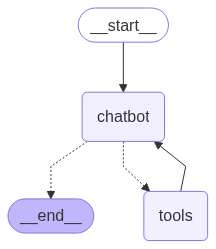

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "今天天气怎么样", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://weather.cma.cn/", "title": "天气预报: 中国气象局", "content": "[成都](https://weather.cma.cn/web/weather/S1003.html) [北京](https://weather.cma.cn/web/weather/54511.html) [南京](https://weather.cma.cn/web/weather/58238.html) [南昌](https://weather.cma.cn/web/weather/58606.html) [合肥](https://weather.cma.cn/web/weather/58321.html) [哈尔滨](https://weather.cma.cn/web/weather/50953.html) [徐家汇](https://weather.cma.cn/web/weather/58367.html) [拉萨](https://weather.cma.cn/web/weather/55591.html) [昆明](https://weather.cma.cn/web/weather/56778.html) [杭州](https://weather.cma.cn/web/weather/58457.html) [武汉](https://weather.cma.cn/web/weather/57494.html) [沈阳](https://weather.cma.cn/web/weather/54342.html) [沙坪坝](https://weather.cma.cn/web/weather/57516.html) [海口](https://weather.cma.cn/web/weather/59758.html) [深圳](https://weather.cma.cn/web/weather/59493.html) [西宁](https://weather.cma.cn/web